In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 100,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = False))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.845679012345679, Loss: 0.6776357580114294
Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.6752108821162471
Checkpoint 300, Accuracy: 0.8395061728395061, Loss: 0.6778445067229094
Checkpoint 400, Accuracy: 0.8395061728395061, Loss: 0.6775094491464121
Checkpoint 500, Accuracy: 0.8395061728395061, Loss: 0.6702009836832682


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [[0.31387162]
 [0.42506802]
 [0.26106033]]
[1. 0. 0.] <-> [[0.68894774]
 [0.21022178]
 [0.10083048]]
[1. 0. 0.] <-> [[0.87629014]
 [0.01135139]
 [0.11235847]]
[1. 0. 0.] <-> [[0.7308041 ]
 [0.18694694]
 [0.08224901]]
[0. 0. 1.] <-> [[0.03358746]
 [0.4119312 ]
 [0.5544813 ]]
[1. 0. 0.] <-> [[0.45693657]
 [0.34002328]
 [0.20304021]]
[0. 1. 0.] <-> [[0.9433305 ]
 [0.02877841]
 [0.02789108]]
[1. 0. 0.] <-> [[0.49923822]
 [0.30946672]
 [0.19129512]]
[1. 0. 0.] <-> [[0.4457384 ]
 [0.34848976]
 [0.2057718 ]]
[1. 0. 0.] <-> [[0.6333248 ]
 [0.23958747]
 [0.12708773]]
[1. 0. 0.] <-> [[0.4229193 ]
 [0.36460575]
 [0.21247496]]
[1. 0. 0.] <-> [[0.8895734 ]
 [0.01256684]
 [0.09785975]]
[0. 0. 1.] <-> [[0.02453066]
 [0.39122146]
 [0.5842479 ]]
[0. 0. 1.] <-> [[0.05771871]
 [0.44414356]
 [0.49813777]]
[1. 0. 0.] <-> [[0.30896047]
 [0.42728955]
 [0.26375002]]
[1. 0. 0.] <-> [[0.88091767]
 [0.01174524]
 [0.10733708]]
[1. 0. 0.] <-> [[0.9321857 ]
 [0.05383307]
 [0.01398121]]
[0. 1. 0.] <->

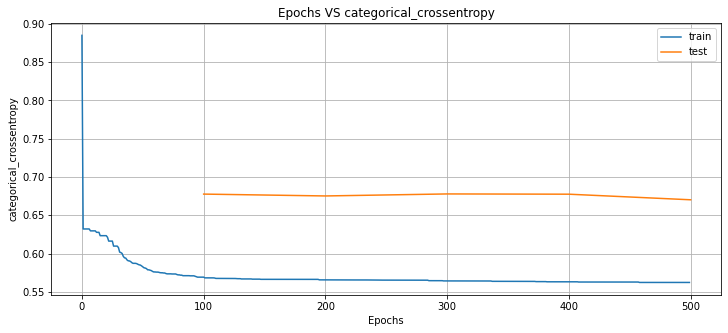

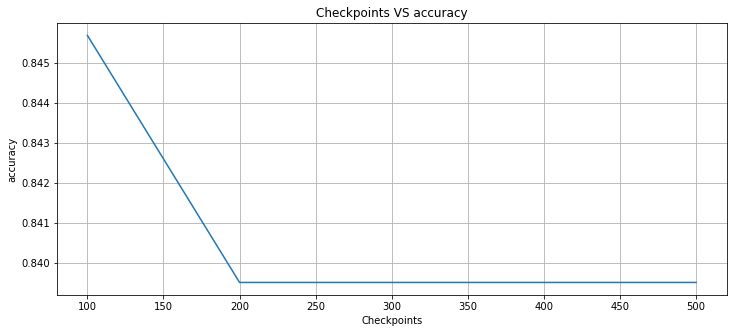

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.845679012345679, 'mean_square_error': 2.954588104369218, 'categorical_crossentropy': 0.6776357580114294, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 4}, 1: {'tp_hit': 4, 'fp_hit': 7, 'tn_hit': 84, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 8}}, 'checkpoint': 100} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.9442279187869542, 'categorical_crossentropy': 0.6752108821162471, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 5}, 1: {'tp_hit': 4, 'fp_hit': 8, 'tn_hit': 83, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 8}}, 'checkpoint': 200} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.9350649088982794, 'categorical_crossentropy': 0.6778445067229094, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 5}, 1: {'tp_hit': 5, 'fp_hit': 9, 'tn_hit': 82, 'fn_hit': 12}, 2: {'tp_hit': 6, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.9094664 ]
 [ 1.1941377 ]
 [-0.26408276]
 [-0.32416767]
 [-0.05672522]]
 bias: [-3.]

Neuron 1: weights:
[[-0.19692236]
 [-1.7729203 ]
 [-0.71499753]
 [ 0.07737454]
 [ 1.4929463 ]]
 bias: [3.]

Neuron 2: weights:
[[ 2.8825243]
 [ 3.       ]
 [-0.6635249]
 [ 1.2715919]
 [ 2.6572175]]
 bias: [0.56080437]

Neuron 3: weights:
[[ 0.35044923]
 [ 0.4721265 ]
 [-0.923961  ]
 [-0.26559493]
 [-0.5725573 ]]
 bias: [-1.9630611]

$
Layer 2
Neuron 0: weights:
[[-0.09866619]
 [ 3.        ]
 [-3.        ]
 [-1.2177217 ]]
 bias: [0.15432076]

Neuron 1: weights:
[[-1.342948 ]
 [-1.0582099]
 [-0.8911341]
 [-2.737633 ]]
 bias: [1.5757571]

Neuron 2: weights:
[[ 3.        ]
 [-2.741988  ]
 [ 0.4877316 ]
 [ 0.36306357]]
 bias: [0.90062517]

$

